### Import Standard Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

### Read and Understand the data

In [14]:
costs = pd.read_csv("healthcare_costs.csv")

costs = costs.drop(['PatientID'],axis=1)

costs_cp = costs.copy()
costs_cp.head()

,Age,BMI,SmokingStatus,ChronicCondition,AnnualCost
0,58,37.0,Non-Smoker,Yes,6725.12
1,71,33.1,Smoker,Yes,17359.16
2,48,28.2,Smoker,Yes,7259.34
3,34,18.8,Non-Smoker,Yes,12287.21
4,62,38.8,Non-Smoker,Yes,8334.85


##### Since PatientID is just unique identifier and doesn't hold any value in modeling it could be dropped.

### Exploratory Data Analysis

In [828]:
#check if there are any null values
costs_cp.isna().sum().sort_values()

Age                 0
BMI                 0
SmokingStatus       0
ChronicCondition    0
AnnualCost          0
dtype: int64

In [830]:
#check for descriptive statistics
costs_cp.describe()

,Age,BMI,AnnualCost
count,50.000000,50.000000,50.000000
mean,51.860000,29.260000,10081.385200
std,17.700467,6.101923,2575.747173
min,21.000000,18.800000,5150.220000
25%,40.000000,24.500000,8223.007500
50%,50.500000,29.900000,9978.370000
75%,67.500000,34.025000,11866.262500
max,79.000000,39.300000,17359.160000


In [832]:
#check for datatypes
costs_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               50 non-null     int64  
 1   BMI               50 non-null     float64
 2   SmokingStatus     50 non-null     object 
 3   ChronicCondition  50 non-null     object 
 4   AnnualCost        50 non-null     float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.1+ KB


In [584]:
# costs_cp['logBMI'] = np.log1p(costs_cp['BMI'])
# costs_cp['logAge'] = np.log1p(costs_cp['Age'])
# costs_cp['logAnnualCost'] = np.log1p(costs_cp['AnnualCost'])

### Distribution of AnnualCost

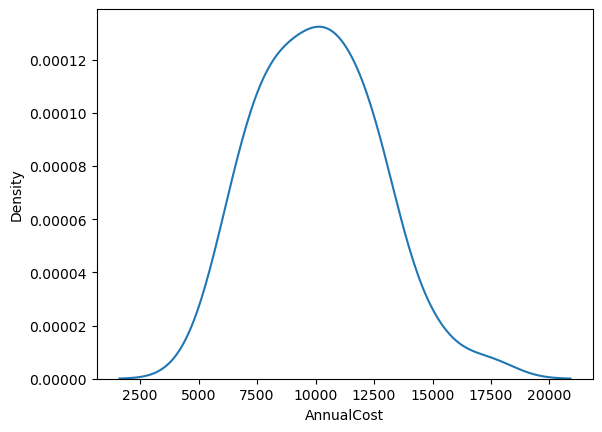

In [586]:
sns.kdeplot(costs_cp['AnnualCost'])
plt.savefig("annual_cost_distribution.png", dpi=300)

##### Distribution is slightly right-skewed and the log transforamtion is not strictly necessary

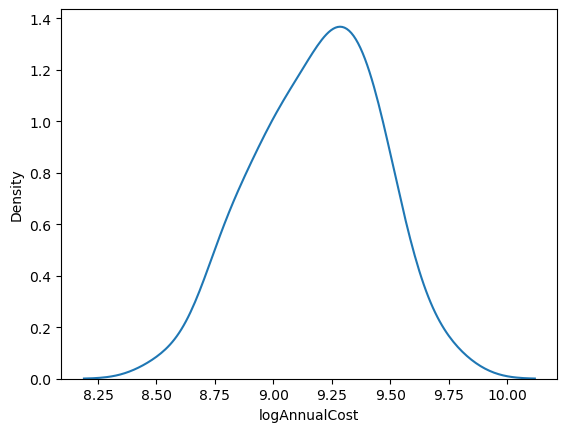

In [588]:
sns.kdeplot(costs_cp['logAnnualCost'])
plt.savefig("log_annual_cost_distribution.png", dpi=300)

### Distribution of Age

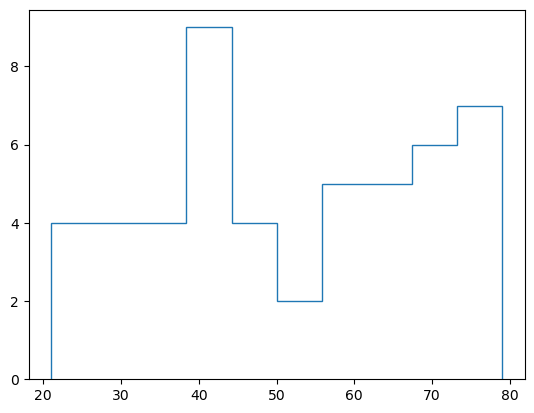

In [590]:
plt.hist('Age',data=costs_cp,bins=10, histtype='step')
plt.show()

#### Age is not normally distributed

### Age Vs BMI

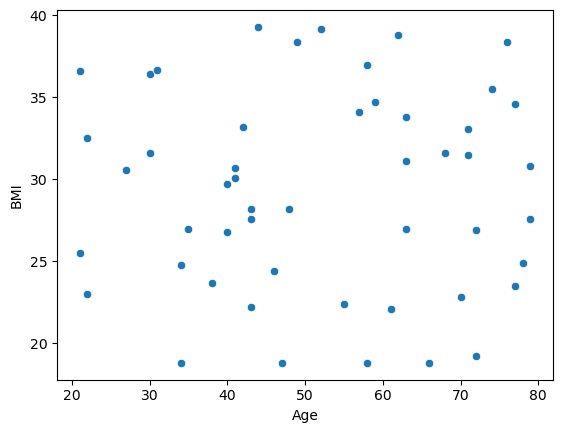

In [593]:
sns.scatterplot(x="Age",y="BMI", data=costs_cp)
plt.show()

#### weekly correlated (no correlation)

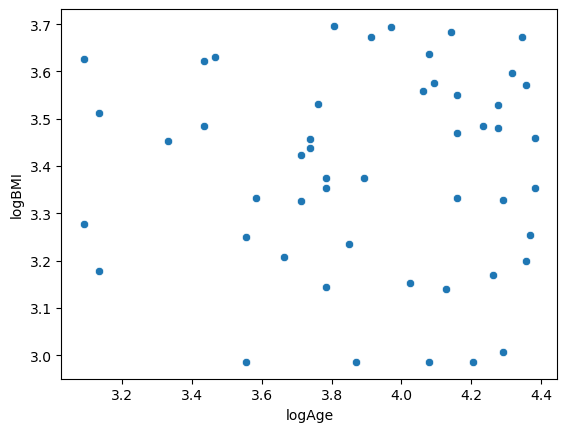

In [595]:
sns.scatterplot(x="logAge",y="logBMI", data=costs_cp)
plt.show()

##### There is no change in the relation between age and bmi after applying log transformation

### Age Vs Annual Cost (Hue = SmokingStatus)

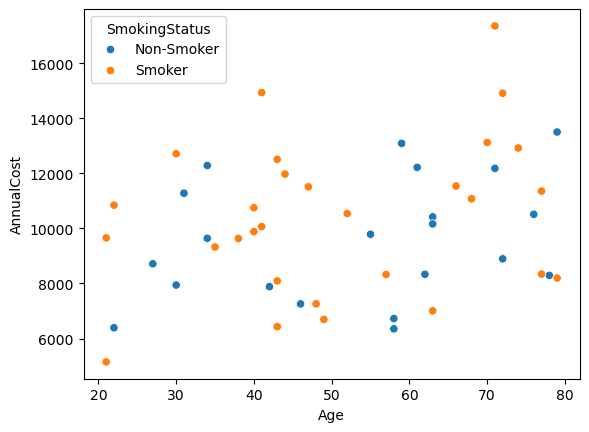

In [598]:
sns.scatterplot(x="Age",y="AnnualCost", hue='SmokingStatus', data=costs_cp)
plt.show()

#### Slightly correlated with hue as SmokingStatus

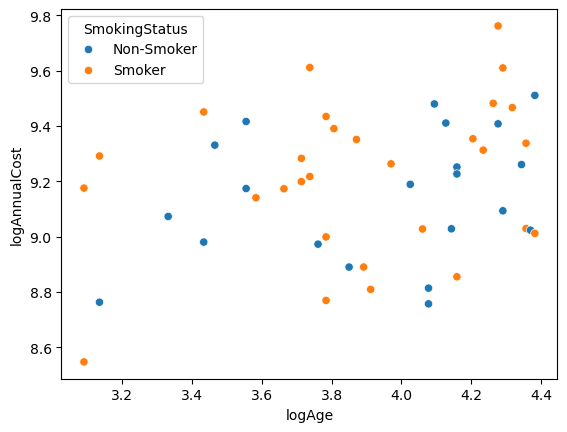

In [600]:
sns.scatterplot(x="logAge",y="logAnnualCost", hue='SmokingStatus', data=costs_cp)
plt.show()

##### There is no change in the relation between annualcost and age after applying log transformation

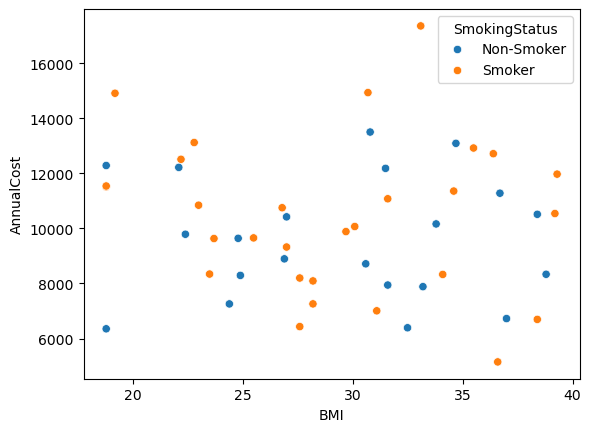

In [602]:
sns.scatterplot(x="BMI",y="AnnualCost",hue="SmokingStatus", data=costs_cp)
plt.show()

#### there is no much of interpretation from the above graph

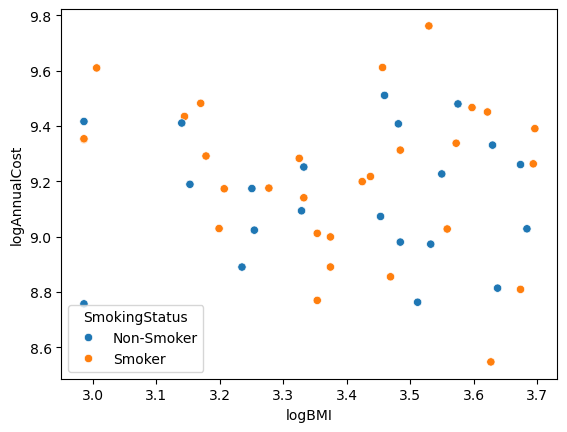

In [604]:
sns.scatterplot(x="logBMI",y="logAnnualCost",hue="SmokingStatus", data=costs_cp)
plt.show()

##### There is no change in the relation between annualcost and bmi after applying log transformation

### Distribution of Smoking Status

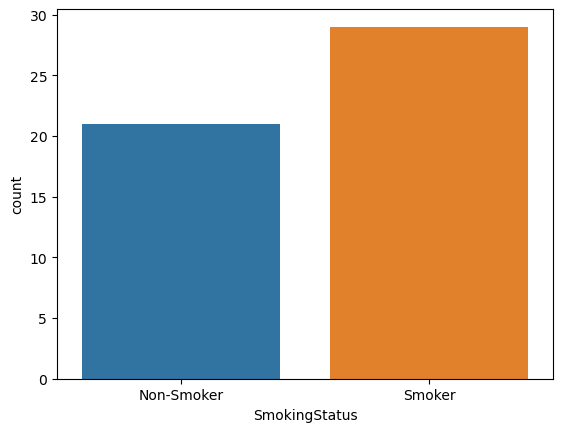

In [607]:
sns.countplot(data=costs_cp,x="SmokingStatus", hue="SmokingStatus")
plt.show()

#### Distribution is not overly Skewed (Smokers are more compared to Non-Smokers)

### Distribution of ChronicCondtion

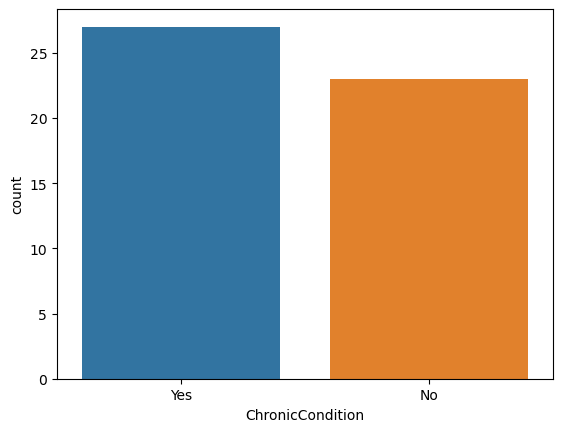

In [610]:
sns.countplot(data=costs_cp,x="ChronicCondition",hue="ChronicCondition")
plt.show()

#### Distribution is not overly Skewed (Yes are more compared to No in ChronicCondition Feature)

### Box Plot -  Checkfor an outliers in AnnualCost(Target Variable)

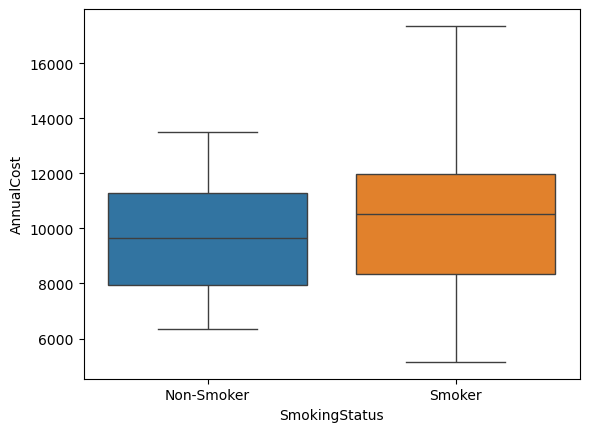

In [613]:
sns.boxplot(data=costs_cp, x="SmokingStatus",y="AnnualCost",hue="SmokingStatus")
plt.show()

#### AnnualCost is more when SmokingStatus is a Smoker

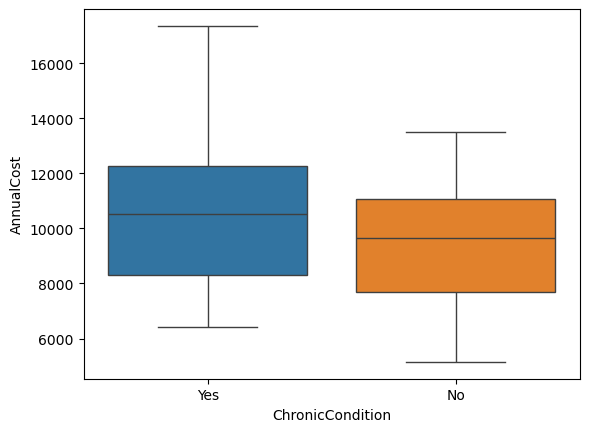

In [615]:
sns.boxplot(data=costs_cp, x="ChronicCondition",y="AnnualCost",hue="ChronicCondition")
plt.show()

#### AnnualCost is more when ChronicCondition is a Yes

### Distribution between Age and ChronicCondition

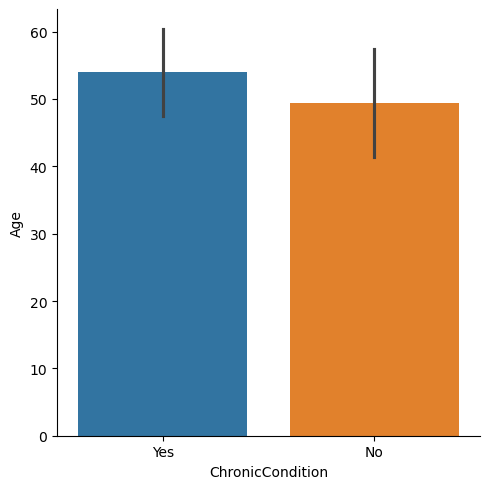

In [618]:
sns.catplot(data=costs_cp, x="ChronicCondition", y="Age",kind="bar",hue="ChronicCondition")
plt.show()

#### ChronicCondtion occurs is more in aged patients

### Bi-Variate Analysis (How does SmokingCondition and ChronicCondtion Relate with AnnualCost

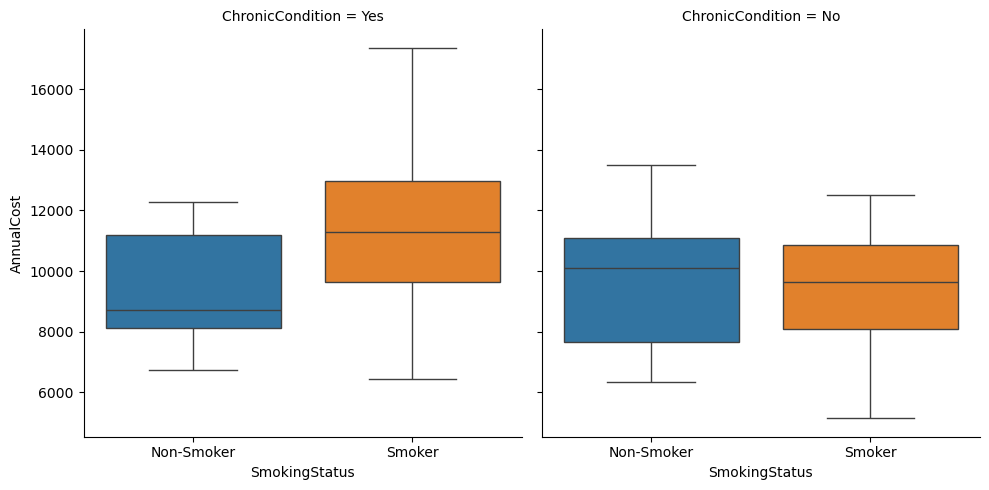

In [621]:
sns.catplot(data=costs_cp, x="SmokingStatus",y="AnnualCost",col="ChronicCondition",kind="box",hue="SmokingStatus")
plt.show()

#### When there is a chronicConditon and Patient is a Smoker, The AnnualCost is more 

###### The median AnnualCost for patients with SmokingCondtion='Smoker' and ChronicCondtion='Yes' is more compared to patients with SmokingCondtion='Smoker' and ChronicCondtion='No'

### Statistics

In [624]:
#check for correlation
costs_cp[['Age', 'BMI', 'AnnualCost']].corr()

,Age,BMI,AnnualCost
Age,1.000000,-0.006628,0.262913
BMI,-0.006628,1.000000,-0.092863
AnnualCost,0.262913,-0.092863,1.000000


#### There is no correlation between Age and BMI, but slight correlation between Age and AnnualCost

In [26]:
#check for multi-collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pandas as pd

X = sm.add_constant(costs_cp[['Age', 'BMI']])  # include constant/intercept
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["feature"] = X.columns
print(vif)

         VIF feature
0  33.339837   const
1   1.000447     Age
2   1.000447     BMI


#### There is no multi-collinearity between Age and BMI since VIF is < 5

##### VIF checks whether your predictors are redundant or highly correlated with each other, which can hurt your model stability.

##### Target Variable(AnnualCost) Shouldn't be added as it will give invalid VIF

### Preprocessing the data

#### Check for an outliers in annual costs

In [18]:
#get the quantiles and iqr for annualcosts to remove an outlier

def remove_outliers(df,colname):
    
    seventy_fifth = np.quantile(df[colname],q=0.75)
    twenty_fifth = np.quantile(df[colname],q=0.25)
    iqr = seventy_fifth - twenty_fifth
    
    #get lower and upper boundaries
    lower = twenty_fifth - (1.5*iqr)
    upper = seventy_fifth + (1.5*iqr)
    
    df = df[(df[colname] > lower) & (df[colname] < upper)]
    return df

In [20]:
costs_cp = remove_outliers(costs_cp,'AnnualCost')
costs_cp = remove_outliers(costs_cp,'BMI')

In [22]:
#Feature Engineering to create Categories to train the model

def create_categories(df,col_name,new_col_name,labels):

    min_quantile = df[col_name].min()
    twenty_fifth_quantile = np.quantile(a=df[col_name],q=0.25)
    median_quantile = np.quantile(a=df[col_name],q=0.50)
    seventy_fifth_quantile = np.quantile(a=df[col_name],q=0.75)
    max_quantile = df[col_name].max()
    
    bins = [0, min_quantile, twenty_fifth_quantile, median_quantile, seventy_fifth_quantile, max_quantile]
    df[new_col_name] = pd.cut(x=df[col_name],bins=bins,labels=labels)

    return df

In [24]:
costs_cp = create_categories(costs_cp,col_name="AnnualCost", new_col_name="CostCat",labels=['Minimum','Least','Median','Upper-Median','Maximum'])
costs_cp = create_categories(costs_cp,col_name="BMI", new_col_name="BMICat",labels=['L','ML','H','MH','VH'])
costs_cp = create_categories(costs_cp,col_name='Age', new_col_name="AgeCat", labels=['Very-Young','Young-Adult','Middle-Aged','Late-Middle-Age','Senior'])

In [673]:
costs_cp.head()

,Age,BMI,SmokingStatus,ChronicCondition,AnnualCost,CostCat,BMICat,AgeCat
0,58,37.0,Non-Smoker,Yes,6725.12,Least,VH,Late-Middle-Age
2,48,28.2,Smoker,Yes,7259.34,Least,H,Middle-Aged
3,34,18.8,Non-Smoker,Yes,12287.21,Maximum,L,Young-Adult
4,62,38.8,Non-Smoker,Yes,8334.85,Median,VH,Late-Middle-Age
5,27,30.6,Non-Smoker,Yes,8715.53,Median,MH,Young-Adult


#### BMICategories & SmokingStatus Vs AnnualCost

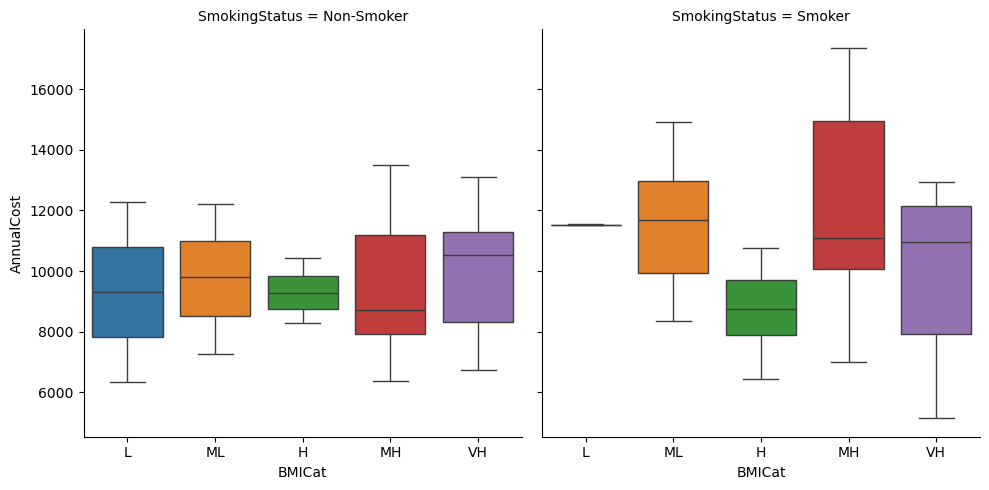

In [53]:
sns.catplot(data=costs_cp, x="BMICat", y="AnnualCost",col="SmokingStatus",kind="box",hue="BMICat")
plt.show()

###### AnnualCost is lower for patients with ‘H’ BMI across both Non-Smokers and Smokers.
###### AnnualCost is higher for patients with ‘VH’ and ‘L’ BMI among both Non-Smokers and Smokers.

#### BMICategories & AgeCategories Vs AnnualCost

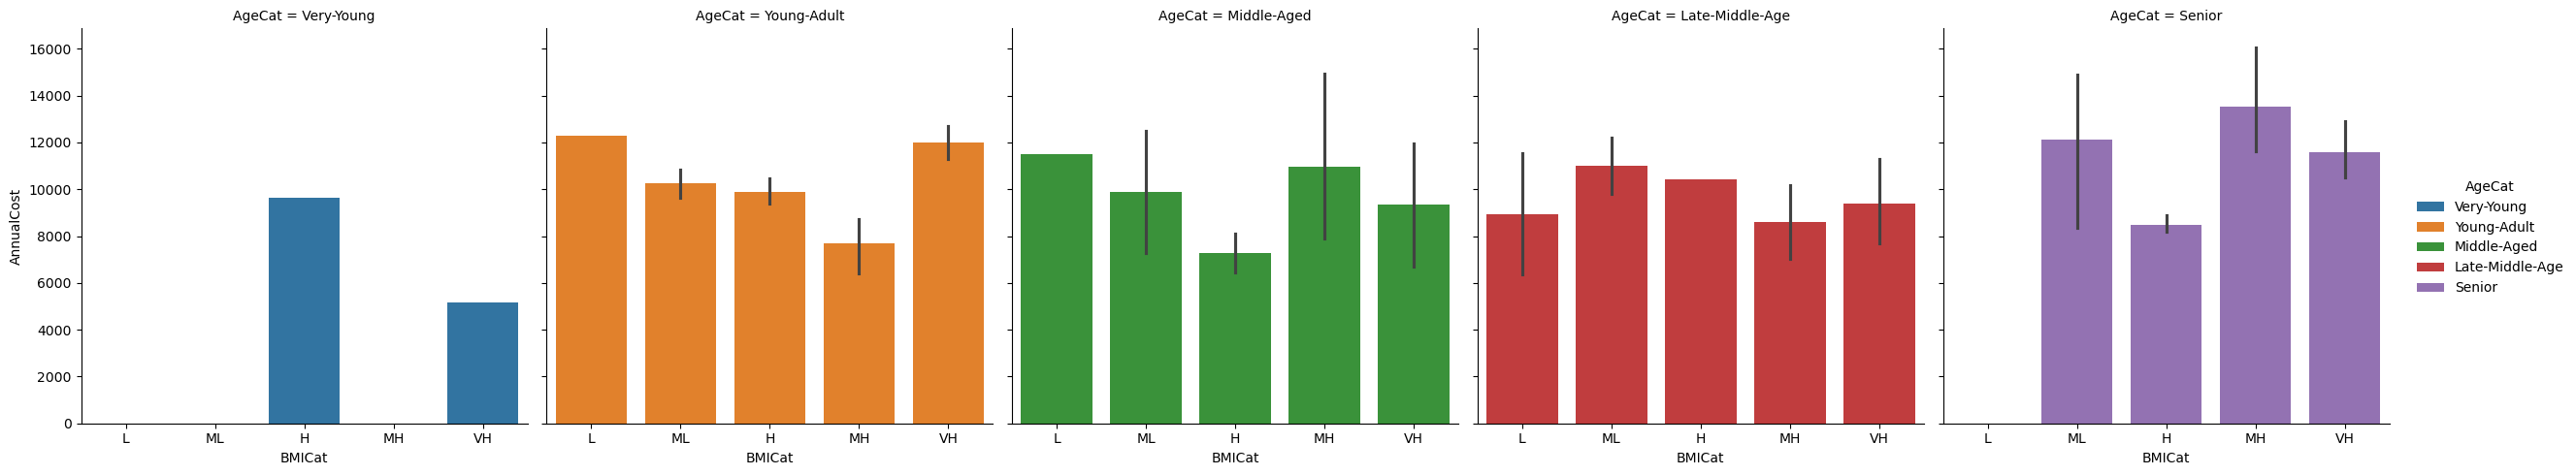

In [56]:
sns.catplot(data=costs_cp, x="BMICat", y="AnnualCost",col="AgeCat",kind="bar",hue="AgeCat")
plt.show()

##### No Data: BMICategories 'L', 'ML', 'MH' for AgeCategories 'Very-Young' / BMICategories 'L' for AgeCategories 'Senior'

###### AnnualCost is highest for 'H' BMI category among Very Young, while 'VH' incurs the lowest.
###### AnnualCost is highest for 'L' and 'VH' BMI categories among Young Adults, while 'MH' incurs the lowest.
###### AnnualCost is highest for 'L' and 'MH' BMI categories among Middle-Aged individuals, while 'H' incurs the lowest.
###### AnnualCost is highest for 'ML' and 'VH' BMI categories among Late Middle-Aged individuals, while 'MH' incurs the lowest.
###### AnnualCost is highest for 'MH' and 'ML' BMI categories among Seniors, while 'H' incurs the lowest.

#### BMICategories & AgeCategories Vs AnnualCost

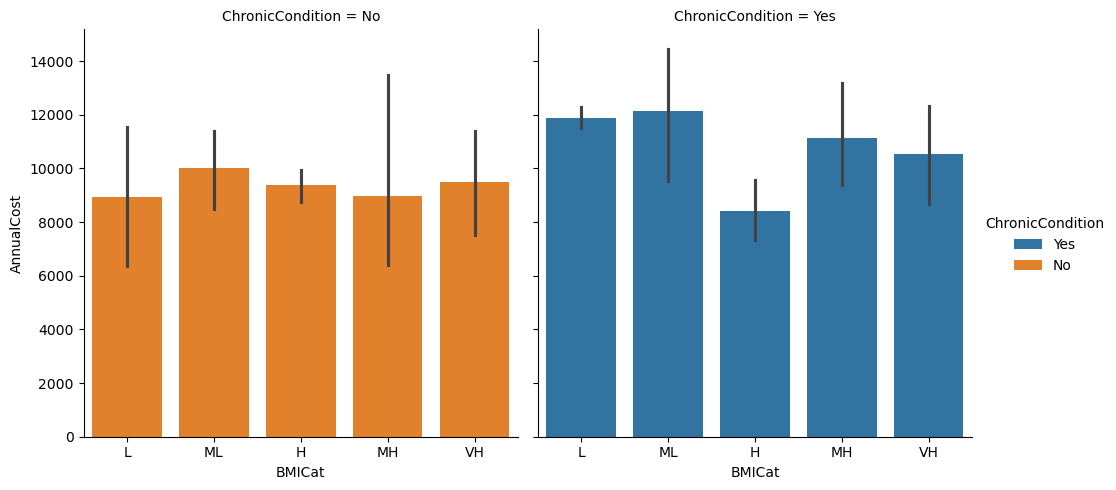

In [60]:
sns.catplot(data=costs_cp, x="BMICat", y="AnnualCost",col="ChronicCondition",kind="bar",hue="ChronicCondition",col_order=['No','Yes'])
plt.show()

###### AnnualCost is high for ‘L’/‘ML’ without Chronic Conditions, and ‘ML’/‘VH’ with Chronic Conditions.
###### Annual cost is low for 'MH' without Chronic Conditions, and 'H' with Chronic Conditions.

#### Converting Categorical to numerical data

In [753]:
costs_cp = pd.get_dummies(costs_cp,columns=['SmokingStatus','ChronicCondition','CostCat','BMICat','AgeCat'],drop_first=True,dtype=int)
costs_cp.head()

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,BMICat_H,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior
0,58,37.0,6725.12,0,1,1,0,0,0,0,0,0,1,0,0,1,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,1,0,0,0,1,0,0
3,34,18.8,12287.21,0,1,0,0,0,1,0,0,0,0,1,0,0,0
4,62,38.8,8334.85,0,1,0,1,0,0,0,0,0,1,0,0,1,0
5,27,30.6,8715.53,0,1,0,1,0,0,0,0,1,0,1,0,0,0


### Machine Learning Model (Regression)

#### Linear Regression 

In [757]:
X = costs_cp.drop(['Age','BMI','AnnualCost'],axis=1).values
y = costs_cp['AnnualCost'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

lin_r2_score = r2_score(y_test,y_pred)
lin_r2_score

0.6244204279181095

#### Decision Tree Regressor

In [759]:
kf_dt = KFold(n_splits=4,shuffle=True,random_state=42)
param_grid_dt = {
                'max_depth':np.arange(1,10,1),
                'min_samples_leaf':[1,2,4,6,8,10,20],
                'random_state':[42]
        }

dt = DecisionTreeRegressor(random_state=42)
dt_cv = GridSearchCV(estimator=dt,param_grid=param_grid_dt,cv=kf_dt)
dt_cv.fit(X_train,y_train)
print(dt_cv.best_params_, dt_cv.best_score_)

{'max_depth': 3, 'min_samples_leaf': 2, 'random_state': 42} 0.7806295093800883


In [761]:
test_score_dt = dt_cv.score(X_test,y_test)
test_score_dt

0.7857309827378012

In [765]:
dt_best_model = dt_cv.best_estimator_
dt_best_model.fit(X_train,y_train)
y_pred_dt_best = dt_best_model.predict(X_test)
dt_r2_score = r2_score(y_test,y_pred_dt_best)
dt_r2_score

0.7857309827378012

#### RandomForest Regressor

In [767]:
kf_rf = KFold(n_splits=4,shuffle=True,random_state=42)
param_grid_rf = {
                'max_depth':np.arange(1,10,1),
                'min_samples_leaf': [1,2,4,6,8,10,20],
                'n_estimators': [100,200,300,500],
        }

rf = RandomForestRegressor(random_state=42)
rf_cv = GridSearchCV(estimator=rf,param_grid=param_grid_rf,cv=kf_rf)
rf_cv.fit(X_train,y_train)
print(rf_cv.best_params_, rf_cv.best_score_)

{'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 500} 0.7273287050575712


In [769]:
test_score_rf = rf_cv.score(X_test,y_test)
test_score_rf

0.7730938270498591

In [773]:
rf_best_model = rf_cv.best_estimator_
rf_best_model.fit(X_train,y_train)
y_pred_rf_best = rf_best_model.predict(X_test)
rf_r2_score = r2_score(y_test,y_pred_rf_best)
rf_r2_score

0.7730938270498591

#### AdaBoost Regressor

In [775]:
kf_ad = KFold(n_splits=4,shuffle=True,random_state=42)
param_grid_ad = {
                'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0],
                'n_estimators': [100,200,300,500],
                'random_state':[42]
        }

ad = AdaBoostRegressor(random_state=42)
ad_cv = GridSearchCV(estimator=ad,param_grid=param_grid_ad,cv=kf_ad)
ad_cv.fit(X_train,y_train)
print(ad_cv.best_params_, ad_cv.best_score_)

{'learning_rate': 0.01, 'n_estimators': 500, 'random_state': 42} 0.6915848329791274


In [777]:
test_score_ad = ad_cv.score(X_test,y_test)
test_score_ad

0.7788829940942299

In [781]:
ad_best_model = ad_cv.best_estimator_
ad_best_model.fit(X_train,y_train)
y_pred_ad_best = ad_best_model.predict(X_test)
ada_r2_score = r2_score(y_test,y_pred_ad_best)
ada_r2_score

0.7788829940942299

#### GradientBoosting Regressor

In [783]:
kf_gb = KFold(n_splits=4,shuffle=True,random_state=42)
param_grid_gb = {
                'learning_rate': [0.01, 0.05, 0.1],
                'n_estimators': [100,200,300,500],
                'random_state':[42],
                'max_depth':np.arange(1,5,1),
                'min_samples_leaf': [1,2,4,6,8,10,20]
        }

gb = GradientBoostingRegressor(random_state=42)
gb_cv = GridSearchCV(estimator=gb,param_grid=param_grid_gb,cv=kf_gb)
gb_cv.fit(X_train,y_train)
print(gb_cv.best_params_, gb_cv.best_score_)

{'learning_rate': 0.05, 'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 42} 0.775126853041687


In [785]:
test_score_gb = gb_cv.score(X_test,y_test)
test_score_gb

0.792656836730765

In [787]:
gb_best_model = gb_cv.best_estimator_
gb_best_model.fit(X_train,y_train)
y_pred_gb_best = gb_best_model.predict(X_test)
gb_r2_score = r2_score(y_test,y_pred_gb_best)
gb_r2_score

0.792656836730765

#### Stochastic GradientBoosting

In [789]:
kf_sgb = KFold(n_splits=4,shuffle=True,random_state=42)
param_grid_sgb = {
                'learning_rate': [0.01, 0.05, 0.1],
                'subsample':np.linspace(0.1,0.8,8),
                'n_estimators': [100,200,300,500],
                'max_features':[0.1,0.2,0.3,0.4,0.5],
                'random_state':[42],
                'max_depth':np.arange(1,5,1),
                'min_samples_leaf': [1,2,4,6,8,10,20]
        }

sgb = GradientBoostingRegressor(random_state=42)
sgb_cv = GridSearchCV(estimator=sgb,param_grid=param_grid_sgb,cv=kf_sgb)
sgb_cv.fit(X_train,y_train)
print(sgb_cv.best_params_, sgb_cv.best_score_)

{'learning_rate': 0.1, 'max_depth': 1, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 500, 'random_state': 42, 'subsample': 0.2} 0.7515144567588914


In [791]:
test_score_sgb = sgb_cv.score(X_test,y_test)
test_score_sgb

0.7574058997364855

In [795]:
sgb_best_model = sgb_cv.best_estimator_
sgb_best_model.fit(X_train,y_train)
y_pred_sgb_best = sgb_best_model.predict(X_test)
sgb_r2_score = r2_score(y_test,y_pred_sgb_best)
sgb_r2_score

0.7574058997364855

In [797]:
r2_scores = pd.DataFrame({'models':['lin_reg','decisionT','RandomF','AdaBoost','GradientBoost','StochGradBoost'],
            'R2_scores':[lin_r2_score,dt_r2_score,rf_r2_score,ada_r2_score,gb_r2_score,sgb_r2_score]})

In [799]:
r2_scores.sort_values(by='R2_scores',ascending=False)

,models,R2_scores
4,GradientBoost,0.792657
1,decisionT,0.785731
3,AdaBoost,0.778883
2,RandomF,0.773094
5,StochGradBoost,0.757406
0,lin_reg,0.624420


In [32]:
param_grids = {
               'DecisionTree':{
                   'max_depth':np.arange(1,10,1),
                   'min_samples_leaf':[1,2,4,6,8,10,20],
                   'random_state':[42]
               },
               'RandomForest':{
                   'max_depth':np.arange(1,10,1),
                   'min_samples_leaf': [1,2,4,6,8,10,20],
                   'n_estimators': [100,200,300,500],
                   'random_state':[42]
               },
               'AdaBoost':{
                   'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0],
                   'n_estimators': [100,200,300,500],
                   'random_state':[42]  
               },
               'GradientBoosting':{
                   'learning_rate': [0.01, 0.05, 0.1],
                   'n_estimators': [100,200,300,500],
                   'random_state':[42],
                   'max_depth':np.arange(1,5,1),
                   'min_samples_leaf': [1,2,4,6,8,10,20]
               },
               'SGD':{
                   'learning_rate': [0.01, 0.05, 0.1],
                   'subsample':np.linspace(0.1,0.8,8),
                   'n_estimators': [100,200,300,500],
                   'max_features':[0.1,0.2,0.3,0.4,0.5],
                   'random_state':[42],
                   'max_depth':np.arange(1,5,1),
                   'min_samples_leaf': [1,2,4,6,8,10,20]
               }}

### Utility Function

In [30]:
def Model_Training(X_train, y_train, X_test, y_test, model_names, param_grids=None):
    models = {
        'LinearRegression': LinearRegression(),
        'DecisionTree': DecisionTreeRegressor(),
        'RandomForest': RandomForestRegressor(),
        'AdaBoost': AdaBoostRegressor(),
        'GradientBoosting': GradientBoostingRegressor(),
        'SGD': GradientBoostingRegressor()
    }

    results = []

    for model_name in model_names:
        model = models.get(model_name)
        print(model_name)
        if model is None:
            print(f"Model '{model_name}' not recognized. Skipping.")
            continue


        # If model has no parameters or not in param_grids - direct fit
        if param_grids is None or model_name not in param_grids:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)

            results.append({
                'Model': model_name,
                'BestParams': None,
                'CV_R2_Score': None,
                'Test_R2_Score': r2
            })
        else:
            param_grid = param_grids[model_name]
            kf = KFold(n_splits=4, shuffle=True, random_state=42)
            grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf)
            grid.fit(X_train, y_train)

            best_model = grid.best_estimator_
            best_cv_r2 = grid.best_score_
            test_r2 = r2_score(y_test, best_model.predict(X_test))

            results.append({
                'Model': model_name,
                'BestParams': grid.best_params_,
                'CV_R2_Score': best_cv_r2,
                'Test_R2_Score': test_r2
            })

    return pd.DataFrame(results)

In [805]:
X = costs_cp.drop(['Age','BMI','AnnualCost'],axis=1).values
y = costs_cp['AnnualCost'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

results_df = Model_Training(X_train, y_train, X_test, y_test, model_names=['LinearRegression','DecisionTree',
                                                                           'RandomForest','AdaBoost','GradientBoosting','SGD'], 
                            param_grids=param_grids)

LinearRegression
DecisionTree
RandomForest
AdaBoost
GradientBoosting
SGD


In [807]:
results_df.sort_values(by="Test_R2_Score",ascending=False)

,Model,BestParams,CV_R2_Score,Test_R2_Score
4,GradientBoosting,"{'learning_rate': 0.05, 'max_depth': 1, 'min_s...",0.775127,0.792657
1,DecisionTree,"{'max_depth': 3, 'min_samples_leaf': 2, 'rando...",0.780630,0.785731
3,AdaBoost,"{'learning_rate': 0.01, 'n_estimators': 500, '...",0.691585,0.778883
2,RandomForest,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.727329,0.773094
5,SGD,"{'learning_rate': 0.1, 'max_depth': 1, 'max_fe...",0.751514,0.757406
0,LinearRegression,None,NaN,0.624420


#### Model with less engineered features 

In [172]:
costs_1 = costs.copy()
#costs_1 = costs_1.drop(['PatientID'],axis=1)
costs_1.head(2)

,Age,BMI,SmokingStatus,ChronicCondition,AnnualCost
0,58,37.0,Non-Smoker,Yes,6725.12
1,71,33.1,Smoker,Yes,17359.16


In [174]:
costs_1 = remove_outliers(costs_1,'AnnualCost')
costs_1 = remove_outliers(costs_1,'BMI')
costs_1.shape

(49, 5)

In [176]:
costs_1 = pd.get_dummies(costs_1,columns=['SmokingStatus','ChronicCondition'],drop_first=True,dtype=int)
costs_1.head(2)

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes
0,58,37.0,6725.12,0,1
2,48,28.2,7259.34,1,1


#### Convert Age And BMI to scaled features and train the model

In [190]:
X1 = costs_1.drop(['AnnualCost'],axis=1).values
y1 = costs_1['AnnualCost'].values
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,test_size=0.3,random_state=42)

#scaling 0/1 info can distort the information especially in training the tree based models
age_index = costs_1.columns.get_loc('Age')
bmi_index = costs_1.columns.get_loc('BMI')
scale_indices = [age_index, bmi_index]

# Copy before modifying
X1_train_scaled = X1_train.copy()
X1_test_scaled = X1_test.copy()

# Scale only selected columns
scaler = StandardScaler()

# Fit and transform training set
X1_train_scaled[:, scale_indices] = scaler.fit_transform(X1_train[:, scale_indices])

# Transform test set using same scaler
X1_test_scaled[:, scale_indices] = scaler.transform(X1_test[:, scale_indices])

results_df1 = Model_Training(X1_train_scaled, y1_train, X1_test_scaled, y1_test, model_names=['LinearRegression','DecisionTree',
                                                                           'RandomForest','AdaBoost','GradientBoosting','SGD'], 
                            param_grids=param_grids)

LinearRegression
DecisionTree
RandomForest
AdaBoost
GradientBoosting
SGD


In [193]:
results_df1

,Model,BestParams,CV_R2_Score,Test_R2_Score
0,LinearRegression,None,NaN,-0.402675
1,DecisionTree,"{'max_depth': 1, 'min_samples_leaf': 20, 'rand...",-0.048561,-0.440765
2,RandomForest,"{'max_depth': 1, 'min_samples_leaf': 20, 'n_es...",-0.046793,-0.464353
3,AdaBoost,"{'learning_rate': 0.05, 'n_estimators': 500, '...",-0.479225,-0.634861
4,GradientBoosting,"{'learning_rate': 0.01, 'max_depth': 1, 'min_s...",-0.048561,-0.440765
5,SGD,"{'learning_rate': 0.1, 'max_depth': 1, 'max_fe...",-0.034042,-0.487981


#### utility function 2

In [691]:
param_grids = {
               'DecisionTree':{
                   'max_depth':np.arange(1,10,1),
                   'min_samples_leaf':[1,2,4,6,8,10,20],
                   'random_state':[42]
               },
               'RandomForest':{
                   'max_depth':np.arange(1,10,1),
                   'min_samples_leaf': [1,2,4,6,8,10,20],
                   'n_estimators': [100,200,300,500],
                   'random_state':[42]
               },
               'AdaBoost':{
                   'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0],
                   'n_estimators': [100,200,300,500],
                   'random_state':[42]  
               },
               'GradientBoosting':{
                   'learning_rate': [0.01, 0.05, 0.1],
                   'n_estimators': [100,200,300,500],
                   'random_state':[42],
                   'max_depth':np.arange(1,5,1),
                   'min_samples_leaf': [1,2,4,6,8,10,20]
               },
               'SGD':{
                   'learning_rate': [0.01, 0.05, 0.1],
                   'subsample':np.linspace(0.1,0.8,8),
                   'n_estimators': [100,200,300,500],
                   'max_features':[0.1,0.2,0.3,0.4,0.5],
                   'random_state':[42],
                   'max_depth':np.arange(1,5,1),
                   'min_samples_leaf': [1,2,4,6,8,10,20]
               }}

In [693]:
def Model_Training_log(X_train, y_train, X_test, y_test, model_names, param_grids=None):
    models = {
        'LinearRegression': LinearRegression(),
        'DecisionTree': DecisionTreeRegressor(),
        'RandomForest': RandomForestRegressor(),
        'AdaBoost': AdaBoostRegressor(),
        'GradientBoosting': GradientBoostingRegressor(),
        'SGD': GradientBoostingRegressor()
    }

    results = []

    # Log-transform the target
    y_train_log = np.log1p(y_train)

    for model_name in model_names:
        model = models.get(model_name)
        print(model_name)
        if model is None:
            print(f"Model '{model_name}' not recognized. Skipping.")
            continue

        if param_grids is None or model_name not in param_grids:
            model.fit(X_train, y_train_log)
            y_pred_log = model.predict(X_test)
            y_pred = np.expm1(y_pred_log)  # inverse-transform
            r2 = r2_score(y_test, y_pred)

            results.append({
                'Model': model_name,
                'BestParams': None,
                'CV_R2_Score': None,
                'Test_R2_Score': r2
            })
        else:
            param_grid = param_grids[model_name]
            kf = KFold(n_splits=4, shuffle=True, random_state=42)
            grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf)
            grid.fit(X_train, y_train_log)

            best_model = grid.best_estimator_
            best_cv_r2 = grid.best_score_

            y_pred_log = best_model.predict(X_test)
            y_pred = np.expm1(y_pred_log)
            test_r2 = r2_score(y_test, y_pred)

            results.append({
                'Model': model_name,
                'BestParams': grid.best_params_,
                'CV_R2_Score': best_cv_r2,
                'Test_R2_Score': test_r2
            })

    return pd.DataFrame(results)

#### Applying log transformation to AnnualCost to train the model

In [695]:
costs_2 = costs.copy()
costs_2.head(2)

,Age,BMI,SmokingStatus,ChronicCondition,AnnualCost
0,58,37.0,Non-Smoker,Yes,6725.12
1,71,33.1,Smoker,Yes,17359.16


In [697]:
costs_2 = create_categories(costs_2,col_name="AnnualCost", new_col_name="CostCat",labels=['Minimum','Least','Median','Upper-Median','Maximum'])
costs_2 = create_categories(costs_2,col_name="BMI", new_col_name="BMICat",labels=['L','ML','H','MH','VH'])
costs_2 = create_categories(costs_2,col_name='Age', new_col_name="AgeCat", labels=['Very-Young','Young-Adult','Middle-Aged','Late-Middle-Age','Senior'])

In [699]:
costs_2 = remove_outliers(costs_2,'AnnualCost')
costs_2 = remove_outliers(costs_2,'BMI')
costs_2.shape

(49, 8)

In [701]:
costs_2 = pd.get_dummies(costs_2,columns=['SmokingStatus','ChronicCondition','CostCat','BMICat','AgeCat'],drop_first=True,dtype=int)
costs_2.head()

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,BMICat_H,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior
0,58,37.0,6725.12,0,1,1,0,0,0,0,0,0,1,0,0,1,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,1,0,0,0,1,0,0
3,34,18.8,12287.21,0,1,0,0,0,1,0,0,0,0,1,0,0,0
4,62,38.8,8334.85,0,1,0,1,0,0,0,0,0,1,0,0,1,0
5,27,30.6,8715.53,0,1,0,1,0,0,0,0,1,0,1,0,0,0


In [703]:
X2 = costs_2.drop(['Age','BMI','AnnualCost'],axis=1).values
y2 = costs_2['AnnualCost'].values
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,test_size=0.3,random_state=42)

results_df2 = Model_Training_log(X2_train, y2_train, X2_test, y2_test, model_names=['LinearRegression','DecisionTree',
                                                                           'RandomForest','AdaBoost','GradientBoosting','SGD'], 
                            param_grids=param_grids)

LinearRegression
DecisionTree
RandomForest
AdaBoost
GradientBoosting
SGD


In [709]:
results_df2.sort_values(by="Test_R2_Score",ascending=False)

,Model,BestParams,CV_R2_Score,Test_R2_Score
3,AdaBoost,"{'learning_rate': 0.7, 'n_estimators': 100, 'r...",0.648256,0.755674
2,RandomForest,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.643044,0.749676
1,DecisionTree,"{'max_depth': 2, 'min_samples_leaf': 6, 'rando...",0.622992,0.732740
4,GradientBoosting,"{'learning_rate': 0.1, 'max_depth': 1, 'min_sa...",0.714789,0.723553
5,SGD,"{'learning_rate': 0.1, 'max_depth': 1, 'max_fe...",0.691495,0.699403
0,LinearRegression,None,NaN,0.585388


#### Limited Feature Engineering with log transformed AnnualCost

In [729]:
costs_3 = costs.copy()
costs_3 = remove_outliers(costs_3,'AnnualCost')
costs_3 = remove_outliers(costs_3,'BMI')
costs_3 = pd.get_dummies(costs_3,columns=['SmokingStatus','ChronicCondition'],drop_first=True,dtype=int)
costs_3.head(2)

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes
0,58,37.0,6725.12,0,1
2,48,28.2,7259.34,1,1


In [720]:
X3 = costs_3.drop(['AnnualCost'],axis=1).values
y3 = costs_3['AnnualCost'].values
X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3,test_size=0.3,random_state=42)

#scaling 0/1 info can distort the information especially in training the tree based models
age_index = costs_3.columns.get_loc('Age')
bmi_index = costs_3.columns.get_loc('BMI')
scale_indices = [age_index, bmi_index]

# Copy before modifying
X3_train_scaled = X3_train.copy()
X3_test_scaled = X3_test.copy()

# Scale only selected columns
scaler = StandardScaler()

# Fit and transform training set
X3_train_scaled[:, scale_indices] = scaler.fit_transform(X3_train[:, scale_indices])

# Transform test set using same scaler
X3_test_scaled[:, scale_indices] = scaler.transform(X3_test[:, scale_indices])

results_df3 = Model_Training_log(X3_train_scaled, y3_train, X3_test_scaled, y3_test, model_names=['LinearRegression','DecisionTree',
                                                                           'RandomForest','AdaBoost','GradientBoosting','SGD'], 
                            param_grids=param_grids)

LinearRegression
DecisionTree
RandomForest
AdaBoost
GradientBoosting
SGD


In [725]:
results_df3.sort_values(by="Test_R2_Score",ascending=False)

,Model,BestParams,CV_R2_Score,Test_R2_Score
0,LinearRegression,None,NaN,-0.609933
1,DecisionTree,"{'max_depth': 1, 'min_samples_leaf': 20, 'rand...",-0.039251,-0.704741
4,GradientBoosting,"{'learning_rate': 0.01, 'max_depth': 1, 'min_s...",-0.039251,-0.704741
2,RandomForest,"{'max_depth': 1, 'min_samples_leaf': 20, 'n_es...",-0.038226,-0.740251
5,SGD,"{'learning_rate': 0.1, 'max_depth': 1, 'max_fe...",-0.028634,-0.760941
3,AdaBoost,"{'learning_rate': 0.3, 'n_estimators': 100, 'r...",-0.350153,-0.945112


#### Comparing the models

In [809]:
results_df.sort_values(by="Test_R2_Score",ascending=False)

,Model,BestParams,CV_R2_Score,Test_R2_Score
4,GradientBoosting,"{'learning_rate': 0.05, 'max_depth': 1, 'min_s...",0.775127,0.792657
1,DecisionTree,"{'max_depth': 3, 'min_samples_leaf': 2, 'rando...",0.780630,0.785731
3,AdaBoost,"{'learning_rate': 0.01, 'n_estimators': 500, '...",0.691585,0.778883
2,RandomForest,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.727329,0.773094
5,SGD,"{'learning_rate': 0.1, 'max_depth': 1, 'max_fe...",0.751514,0.757406
0,LinearRegression,None,NaN,0.624420


In [741]:
results_df2.sort_values(by="Test_R2_Score",ascending=False)

,Model,BestParams,CV_R2_Score,Test_R2_Score
3,AdaBoost,"{'learning_rate': 0.7, 'n_estimators': 100, 'r...",0.648256,0.755674
2,RandomForest,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.643044,0.749676
1,DecisionTree,"{'max_depth': 2, 'min_samples_leaf': 6, 'rando...",0.622992,0.732740
4,GradientBoosting,"{'learning_rate': 0.1, 'max_depth': 1, 'min_sa...",0.714789,0.723553
5,SGD,"{'learning_rate': 0.1, 'max_depth': 1, 'max_fe...",0.691495,0.699403
0,LinearRegression,None,NaN,0.585388


##### results_df -> Multiple feature engineering
##### results_df2 -> Multiple feature engineering with log transformation applied to AnnualCost

#### More feature Engineering

In [6]:
def CreateDataForTraining(df):
    df = df.copy()
    df = create_categories(df,col_name="AnnualCost", new_col_name="CostCat",labels=['Minimum','Least','Median','Upper-Median','Maximum'])
    df = create_categories(df,col_name="BMI", new_col_name="BMICat",labels=['L','ML','H','MH','VH'])
    df = create_categories(df,col_name='Age', new_col_name="AgeCat", labels=['Very-Young','Young-Adult','Middle-Aged','Late-Middle-Age','Senior'])
    df = remove_outliers(df,'AnnualCost')
    df = remove_outliers(df,'BMI')
    df = pd.get_dummies(df,columns=['SmokingStatus','ChronicCondition','CostCat','BMICat','AgeCat'],drop_first=True,dtype=int)
    return df

In [858]:
costs_4 = CreateDataForTraining(costs)
costs_4.head(2)

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,BMICat_H,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior
0,58,37.0,6725.12,0,1,1,0,0,0,0,0,0,1,0,0,1,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,1,0,0,0,1,0,0


#####  New Feature -> Smoker * Chronic

In [860]:
costs_4['smoker_with_chronic'] = costs_4["SmokingStatus_Smoker"]*costs_4["ChronicCondition_Yes"]
costs_4.head(2)

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,BMICat_H,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior,smoker_with_chronic
0,58,37.0,6725.12,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,1,0,0,0,1,0,0,1


In [862]:
X4 = costs_4.drop(['Age','BMI','AnnualCost'],axis=1).values
y4 = costs_4['AnnualCost'].values
X4_train, X4_test, y4_train, y4_test = train_test_split(X4,y4,test_size=0.3,random_state=42)

results_df4 = Model_Training(X4_train, y4_train, X4_test, y4_test, model_names=['LinearRegression','DecisionTree',
                                                                           'RandomForest','AdaBoost','GradientBoosting','SGD'], 
                            param_grids=param_grids)

LinearRegression
DecisionTree
RandomForest
AdaBoost
GradientBoosting
SGD


In [866]:
results_df4.sort_values(by="Test_R2_Score",ascending=False)

,Model,BestParams,CV_R2_Score,Test_R2_Score
4,GradientBoosting,"{'learning_rate': 0.01, 'max_depth': 1, 'min_s...",0.772707,0.793459
1,DecisionTree,"{'max_depth': 3, 'min_samples_leaf': 2, 'rando...",0.779414,0.785731
5,SGD,"{'learning_rate': 0.05, 'max_depth': 1, 'max_f...",0.727953,0.775420
2,RandomForest,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.729232,0.773469
3,AdaBoost,"{'learning_rate': 0.1, 'n_estimators': 100, 'r...",0.710618,0.772213
0,LinearRegression,None,NaN,0.610446


#####  New Feature -> Age Categories * Chronic

In [28]:
costs_5 = CreateDataForTraining(costs)
costs_5.head(2)

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,BMICat_H,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior
0,58,37.0,6725.12,0,1,1,0,0,0,0,0,0,1,0,0,1,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,1,0,0,0,1,0,0


In [36]:
costs_5['Young-Adult-Chronic'] = costs_5['AgeCat_Young-Adult']*costs_5['ChronicCondition_Yes']
costs_5['Middle-Aged-Chronic'] = costs_5['AgeCat_Middle-Aged']*costs_5['ChronicCondition_Yes']
costs_5['Late-Middle-Aged-Chronic'] = costs_5['AgeCat_Late-Middle-Age']*costs_5['ChronicCondition_Yes']
costs_5['Senior-Chronic'] = costs_5['AgeCat_Senior']*costs_5['ChronicCondition_Yes']

costs_5.head(2)

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,...,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior,Young-Adult-Chronic,Middle-Aged-Chronic,Late-Middle-Aged-Chronic,Senior-Chronic
0,58,37.0,6725.12,0,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [40]:
X5 = costs_5.drop(['Age','BMI','AnnualCost'],axis=1).values
y5 = costs_5['AnnualCost'].values
X5_train, X5_test, y5_train, y5_test = train_test_split(X5,y5,test_size=0.3,random_state=42)

results_df5 = Model_Training(X5_train, y5_train, X5_test, y5_test, model_names=['LinearRegression','DecisionTree',
                                                                           'RandomForest','AdaBoost','GradientBoosting','SGD'], 
                            param_grids=param_grids)

LinearRegression
DecisionTree
RandomForest
AdaBoost
GradientBoosting
SGD


In [44]:
results_df5.sort_values(by="Test_R2_Score", ascending=False)

,Model,BestParams,CV_R2_Score,Test_R2_Score
4,GradientBoosting,"{'learning_rate': 0.01, 'max_depth': 1, 'min_s...",0.773276,0.793459
1,DecisionTree,"{'max_depth': 3, 'min_samples_leaf': 2, 'rando...",0.778547,0.785731
2,RandomForest,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.727571,0.772888
5,SGD,"{'learning_rate': 0.05, 'max_depth': 1, 'max_f...",0.734048,0.761351
3,AdaBoost,"{'learning_rate': 0.5, 'n_estimators': 100, 'r...",0.725723,0.706335
0,LinearRegression,None,NaN,0.597056


In [46]:
costs_6 = CreateDataForTraining(costs)
costs_6.head(2)

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,BMICat_H,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior
0,58,37.0,6725.12,0,1,1,0,0,0,0,0,0,1,0,0,1,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,1,0,0,0,1,0,0


In [48]:
costs_6['Young-Adult-Chronic'] = costs_6['AgeCat_Young-Adult']*costs_6['ChronicCondition_Yes']
costs_6['Middle-Aged-Chronic'] = costs_6['AgeCat_Middle-Aged']*costs_6['ChronicCondition_Yes']
costs_6['Late-Middle-Aged-Chronic'] = costs_6['AgeCat_Late-Middle-Age']*costs_6['ChronicCondition_Yes']
costs_6['Senior-Chronic'] = costs_6['AgeCat_Senior']*costs_6['ChronicCondition_Yes']

costs_6.head(2)

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,...,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior,Young-Adult-Chronic,Middle-Aged-Chronic,Late-Middle-Aged-Chronic,Senior-Chronic
0,58,37.0,6725.12,0,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


##### Remove the dummy variables for CategoricalAge and ChronicCondition_Yes to train model using blended age–chronic condition categories instead.

In [50]:
X6 = costs_6.drop(['Age','BMI','AnnualCost','AgeCat_Young-Adult','AgeCat_Middle-Aged',
                   'AgeCat_Late-Middle-Age','AgeCat_Senior','ChronicCondition_Yes'],axis=1).values
y6 = costs_6['AnnualCost'].values
X6_train, X6_test, y6_train, y6_test = train_test_split(X6,y6,test_size=0.3,random_state=42)

results_df6 = Model_Training(X6_train, y6_train, X6_test, y6_test, model_names=['LinearRegression','DecisionTree',
                                                                           'RandomForest','AdaBoost','GradientBoosting','SGD'], 
                            param_grids=param_grids)

LinearRegression
DecisionTree
RandomForest
AdaBoost
GradientBoosting
SGD


In [51]:
results_df6.sort_values(by="Test_R2_Score", ascending=False)

,Model,BestParams,CV_R2_Score,Test_R2_Score
4,GradientBoosting,"{'learning_rate': 0.05, 'max_depth': 1, 'min_s...",0.774556,0.795423
1,DecisionTree,"{'max_depth': 3, 'min_samples_leaf': 2, 'rando...",0.702433,0.785731
0,LinearRegression,None,NaN,0.779560
2,RandomForest,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.730970,0.773177
3,AdaBoost,"{'learning_rate': 0.01, 'n_estimators': 300, '...",0.723306,0.773075
5,SGD,"{'learning_rate': 0.1, 'max_depth': 2, 'max_fe...",0.746990,0.649569


In [ ]:
#### Feature BMI * Age* ChronicCondition * SmokingStatus

In [105]:
costs_7 = CreateDataForTraining(costs)
costs_7.head(2)

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,BMICat_H,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior
0,58,37.0,6725.12,0,1,1,0,0,0,0,0,0,1,0,0,1,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,1,0,0,0,1,0,0


In [107]:
costs_7['ML-BMI-Young-Adult-Chronic-Smoking'] = costs_7['BMICat_ML']*costs_7['AgeCat_Young-Adult']*costs_7['ChronicCondition_Yes']*costs_7['SmokingStatus_Smoker']
costs_7['H-BMI-Middle-Aged-Chronic-Smoking'] = costs_7['BMICat_H']*costs_7['AgeCat_Middle-Aged']*costs_7['ChronicCondition_Yes']*costs_7['SmokingStatus_Smoker']
costs_7['MH-BMI-Late-Middle-Age-Chronic-Smoking'] = costs_7['BMICat_MH']*costs_7['AgeCat_Late-Middle-Age']*costs_7['ChronicCondition_Yes']*costs_7['SmokingStatus_Smoker']
costs_7['VH-BMI-Senior-Chronic-Smoking'] = costs_7['BMICat_VH']*costs_7['AgeCat_Senior']*costs_7['ChronicCondition_Yes']*costs_7['SmokingStatus_Smoker']

costs_7.head(2)

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,...,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior,ML-BMI-Young-Adult-Chronic-Smoking,H-BMI-Middle-Aged-Chronic-Smoking,MH-BMI-Late-Middle-Age-Chronic-Smoking,VH-BMI-Senior-Chronic-Smoking
0,58,37.0,6725.12,0,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [109]:
costs_7.columns

Index(['Age', 'BMI', 'AnnualCost', 'SmokingStatus_Smoker',
       'ChronicCondition_Yes', 'CostCat_Least', 'CostCat_Median',
       'CostCat_Upper-Median', 'CostCat_Maximum', 'BMICat_ML', 'BMICat_H',
       'BMICat_MH', 'BMICat_VH', 'AgeCat_Young-Adult', 'AgeCat_Middle-Aged',
       'AgeCat_Late-Middle-Age', 'AgeCat_Senior',
       'ML-BMI-Young-Adult-Chronic-Smoking',
       'H-BMI-Middle-Aged-Chronic-Smoking',
       'MH-BMI-Late-Middle-Age-Chronic-Smoking',
       'VH-BMI-Senior-Chronic-Smoking'],
      dtype='object')

In [111]:
X7 = costs_7.drop(['Age','BMI','AnnualCost',
                   'BMICat_ML','BMICat_H','BMICat_MH','BMICat_VH',
                   'AgeCat_Young-Adult','AgeCat_Middle-Aged','AgeCat_Late-Middle-Age','AgeCat_Senior',
                   'ChronicCondition_Yes','SmokingStatus_Smoker'],axis=1).values
y7 = costs_7['AnnualCost'].values
X7_train, X7_test, y7_train, y7_test = train_test_split(X7,y7,test_size=0.3,random_state=42)

results_df7 = Model_Training(X7_train, y7_train, X7_test, y7_test, model_names=['LinearRegression','DecisionTree',
                                                                           'RandomForest','AdaBoost','GradientBoosting','SGD'], 
                            param_grids=param_grids)

LinearRegression
DecisionTree
RandomForest
AdaBoost
GradientBoosting
SGD


In [112]:
results_df7.sort_values(by="Test_R2_Score", ascending=False)

,Model,BestParams,CV_R2_Score,Test_R2_Score
2,RandomForest,"{'max_depth': 4, 'min_samples_leaf': 1, 'n_est...",0.758118,0.813955
1,DecisionTree,"{'max_depth': 4, 'min_samples_leaf': 1, 'rando...",0.718484,0.813906
0,LinearRegression,None,NaN,0.813906
5,SGD,"{'learning_rate': 0.1, 'max_depth': 4, 'max_fe...",0.840897,0.812296
4,GradientBoosting,"{'learning_rate': 0.1, 'max_depth': 1, 'min_sa...",0.796569,0.809088
3,AdaBoost,"{'learning_rate': 0.7, 'n_estimators': 100, 'r...",0.796460,0.806123


#### Riskscore using SmokingStatus + ChronicCondition + BMI + Age

In [140]:
costs_8 = CreateDataForTraining(costs)
costs_8.head(2)

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,BMICat_H,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior
0,58,37.0,6725.12,0,1,1,0,0,0,0,0,0,1,0,0,1,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,1,0,0,0,1,0,0


In [142]:
costs_8['ML-BMI-Young-Adult-Chronic-Smoking'] = costs_8['BMICat_ML']*costs_8['AgeCat_Young-Adult']*costs_8['ChronicCondition_Yes']*costs_8['SmokingStatus_Smoker']
costs_8['H-BMI-Middle-Aged-Chronic-Smoking'] = costs_8['BMICat_H']*costs_8['AgeCat_Middle-Aged']*costs_8['ChronicCondition_Yes']*costs_8['SmokingStatus_Smoker']
costs_8['MH-BMI-Late-Middle-Age-Chronic-Smoking'] = costs_8['BMICat_MH']*costs_8['AgeCat_Late-Middle-Age']*costs_8['ChronicCondition_Yes']*costs_8['SmokingStatus_Smoker']
costs_8['VH-BMI-Senior-Chronic-Smoking'] = costs_8['BMICat_VH']*costs_8['AgeCat_Senior']*costs_8['ChronicCondition_Yes']*costs_8['SmokingStatus_Smoker']

costs_8.head(2)

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,...,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior,ML-BMI-Young-Adult-Chronic-Smoking,H-BMI-Middle-Aged-Chronic-Smoking,MH-BMI-Late-Middle-Age-Chronic-Smoking,VH-BMI-Senior-Chronic-Smoking
0,58,37.0,6725.12,0,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [144]:
costs_8['RiskScore'] = (
    1 * costs_8['SmokingStatus_Smoker'] +
    1 * costs_8['ChronicCondition_Yes'] +
    1 * costs_8.get('BMICat_ML', 0) +
    2 * costs_8.get('BMICat_H', 0) +
    3 * costs_8.get('BMICat_MH', 0) +
    4 * costs_8.get('BMICat_VH', 0) +
    1 * costs_8.get('AgeCat_Middle-Aged', 0) +
    2 * costs_8.get('AgeCat_Late-Middle-Age', 0) +
    3 * costs_8.get('AgeCat_Senior', 0)
)

costs_8.head()

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,...,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior,ML-BMI-Young-Adult-Chronic-Smoking,H-BMI-Middle-Aged-Chronic-Smoking,MH-BMI-Late-Middle-Age-Chronic-Smoking,VH-BMI-Senior-Chronic-Smoking,RiskScore
0,58,37.0,6725.12,0,1,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,7
2,48,28.2,7259.34,1,1,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,5
3,34,18.8,12287.21,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
4,62,38.8,8334.85,0,1,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,7
5,27,30.6,8715.53,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,4


In [134]:
X8 = costs_8.drop(['Age','BMI','AnnualCost',
                   'BMICat_ML','BMICat_H','BMICat_MH','BMICat_VH',
                   'AgeCat_Young-Adult','AgeCat_Middle-Aged','AgeCat_Late-Middle-Age','AgeCat_Senior',
                   'ChronicCondition_Yes','SmokingStatus_Smoker'],axis=1).values
y8 = costs_8['AnnualCost'].values
X8_train, X8_test, y8_train, y8_test = train_test_split(X8,y8,test_size=0.3,random_state=42)

results_df8 = Model_Training(X8_train, y8_train, X8_test, y8_test, model_names=['LinearRegression','DecisionTree',
                                                                           'RandomForest','AdaBoost','GradientBoosting','SGD'], 
                            param_grids=param_grids)

LinearRegression
DecisionTree
RandomForest
AdaBoost
GradientBoosting
SGD


In [135]:
results_df8.sort_values(by="Test_R2_Score", ascending=False)

,Model,BestParams,CV_R2_Score,Test_R2_Score
2,RandomForest,"{'max_depth': 6, 'min_samples_leaf': 1, 'n_est...",0.793379,0.901780
1,DecisionTree,"{'max_depth': 7, 'min_samples_leaf': 1, 'rando...",0.875933,0.885896
4,GradientBoosting,"{'learning_rate': 0.01, 'max_depth': 4, 'min_s...",0.822888,0.868576
3,AdaBoost,"{'learning_rate': 1.0, 'n_estimators': 100, 'r...",0.814506,0.825771
0,LinearRegression,None,NaN,0.818982
5,SGD,"{'learning_rate': 0.1, 'max_depth': 4, 'max_fe...",0.857871,0.816736


#### Plot a heatmap to understand the correlation

<Axes: >

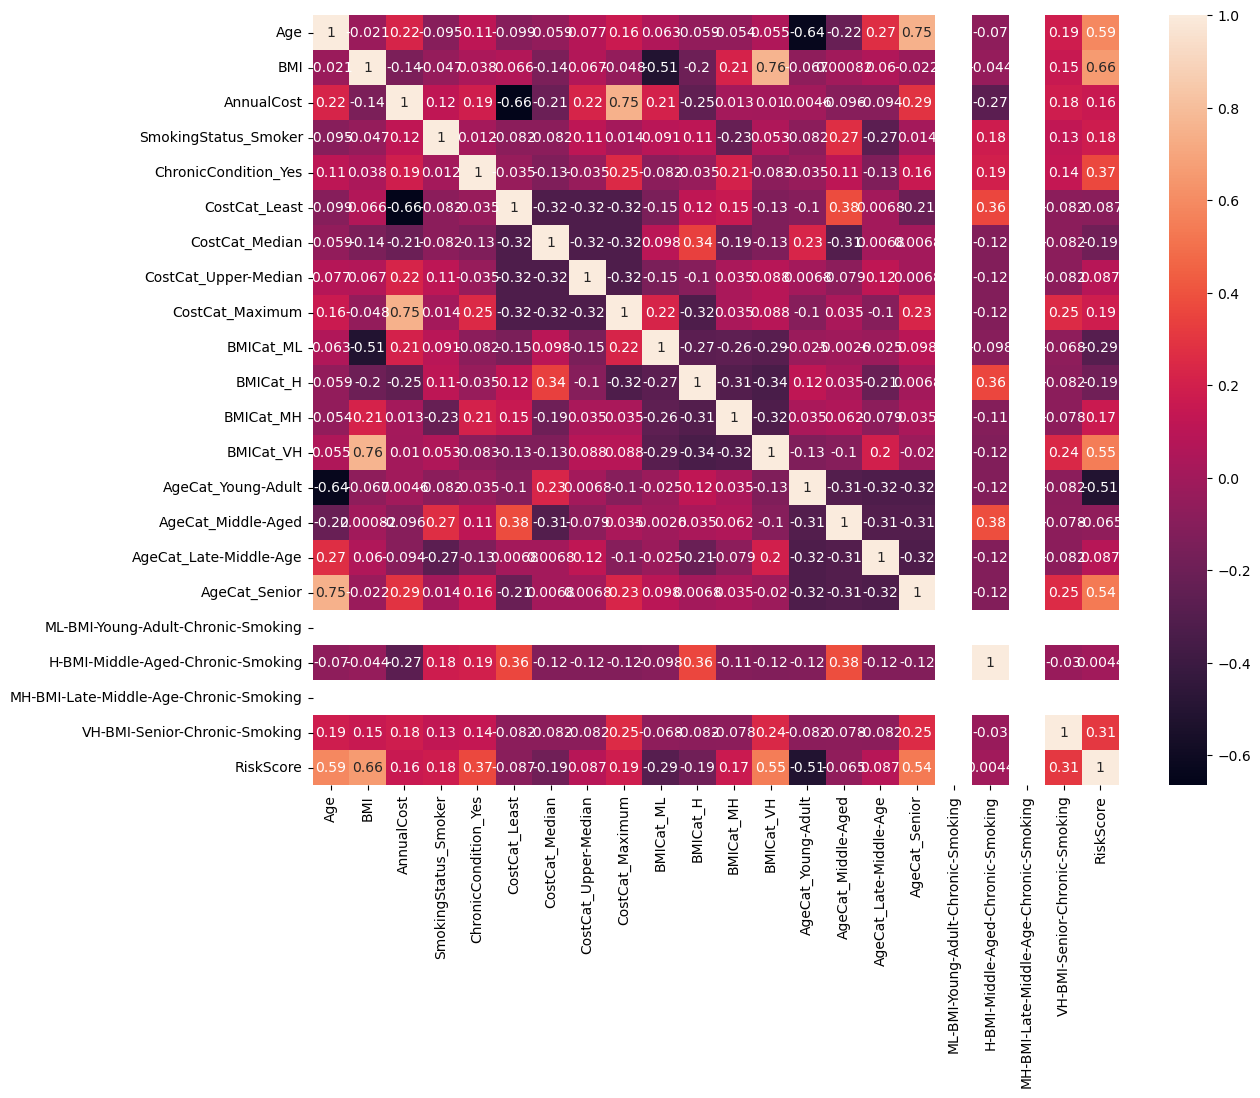

In [158]:
plt.figure(figsize=(13,10))

sns.heatmap(costs_8.corr(),annot=True)

#### Riskscore using SmokingStatus + ChronicCondition + BMI + Age - CostCat

In [162]:
costs_9 = CreateDataForTraining(costs)
costs_9.head(2)

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,BMICat_H,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior
0,58,37.0,6725.12,0,1,1,0,0,0,0,0,0,1,0,0,1,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,1,0,0,0,1,0,0


In [164]:
costs_9['ML-BMI-Young-Adult-Chronic-Smoking'] = costs_9['BMICat_ML']*costs_9['AgeCat_Young-Adult']*costs_9['ChronicCondition_Yes']*costs_9['SmokingStatus_Smoker']
costs_9['H-BMI-Middle-Aged-Chronic-Smoking'] = costs_9['BMICat_H']*costs_9['AgeCat_Middle-Aged']*costs_9['ChronicCondition_Yes']*costs_9['SmokingStatus_Smoker']
costs_9['MH-BMI-Late-Middle-Age-Chronic-Smoking'] = costs_9['BMICat_MH']*costs_9['AgeCat_Late-Middle-Age']*costs_9['ChronicCondition_Yes']*costs_9['SmokingStatus_Smoker']
costs_9['VH-BMI-Senior-Chronic-Smoking'] = costs_9['BMICat_VH']*costs_9['AgeCat_Senior']*costs_9['ChronicCondition_Yes']*costs_9['SmokingStatus_Smoker']

costs_9.head(2)

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,...,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior,ML-BMI-Young-Adult-Chronic-Smoking,H-BMI-Middle-Aged-Chronic-Smoking,MH-BMI-Late-Middle-Age-Chronic-Smoking,VH-BMI-Senior-Chronic-Smoking
0,58,37.0,6725.12,0,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [166]:
costs_9['RiskScore'] = (
    1 * costs_9['SmokingStatus_Smoker'] +
    1 * costs_9['ChronicCondition_Yes'] +
    1 * costs_9.get('BMICat_ML', 0) +
    2 * costs_9.get('BMICat_H', 0) +
    3 * costs_9.get('BMICat_MH', 0) +
    4 * costs_9.get('BMICat_VH', 0) +
    1 * costs_9.get('AgeCat_Middle-Aged', 0) +
    2 * costs_9.get('AgeCat_Late-Middle-Age', 0) +
    3 * costs_9.get('AgeCat_Senior', 0)
)

costs_9.head()

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,...,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior,ML-BMI-Young-Adult-Chronic-Smoking,H-BMI-Middle-Aged-Chronic-Smoking,MH-BMI-Late-Middle-Age-Chronic-Smoking,VH-BMI-Senior-Chronic-Smoking,RiskScore
0,58,37.0,6725.12,0,1,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,7
2,48,28.2,7259.34,1,1,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,5
3,34,18.8,12287.21,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
4,62,38.8,8334.85,0,1,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,7
5,27,30.6,8715.53,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,4


In [168]:
X9 = costs_9.drop(['Age','BMI','AnnualCost',
                   'BMICat_ML','BMICat_H','BMICat_MH','BMICat_VH',
                   'AgeCat_Young-Adult','AgeCat_Middle-Aged','AgeCat_Late-Middle-Age','AgeCat_Senior',
                   'ChronicCondition_Yes','SmokingStatus_Smoker',
                  'CostCat_Least','CostCat_Median','CostCat_Upper-Median','CostCat_Maximum'],axis=1).values
y9 = costs_9['AnnualCost'].values
X9_train, X9_test, y9_train, y9_test = train_test_split(X9,y9,test_size=0.3,random_state=42)

results_df9 = Model_Training(X9_train, y9_train, X9_test, y9_test, model_names=['LinearRegression','DecisionTree',
                                                                           'RandomForest','AdaBoost','GradientBoosting','SGD'], 
                            param_grids=param_grids)

LinearRegression
DecisionTree
RandomForest
AdaBoost
GradientBoosting
SGD


In [170]:
results_df9.sort_values(by="Test_R2_Score", ascending=False)

,Model,BestParams,CV_R2_Score,Test_R2_Score
0,LinearRegression,None,NaN,-0.240291
1,DecisionTree,"{'max_depth': 1, 'min_samples_leaf': 20, 'rand...",-0.048561,-0.440765
4,GradientBoosting,"{'learning_rate': 0.01, 'max_depth': 1, 'min_s...",-0.048561,-0.440765
2,RandomForest,"{'max_depth': 1, 'min_samples_leaf': 20, 'n_es...",-0.046793,-0.464353
5,SGD,"{'learning_rate': 0.1, 'max_depth': 1, 'max_fe...",-0.034042,-0.487981
3,AdaBoost,"{'learning_rate': 1.0, 'n_estimators': 100, 'r...",-0.269520,-0.797791


#### Selected Features from Heatmap above

In [220]:
selected_features = [
    'Age', #0.22
    'BMI', #-0.14
    'RiskScore', #0.16
    'BMICat_MH', #0.013
    'BMICat_VH', #0.010
    'AgeCat_Late-Middle-Age', #0.09
    'AgeCat_Senior', #0.29
    'SmokingStatus_Smoker', #0.12
    'ChronicCondition_Yes' #0.19
]

In [222]:
costs_10 = CreateDataForTraining(costs)
costs_10.head(2)

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,BMICat_H,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior
0,58,37.0,6725.12,0,1,1,0,0,0,0,0,0,1,0,0,1,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,1,0,0,0,1,0,0


In [224]:
costs_10['ML-BMI-Young-Adult-Chronic-Smoking'] = costs_10['BMICat_ML']*costs_10['AgeCat_Young-Adult']*costs_10['ChronicCondition_Yes']*costs_10['SmokingStatus_Smoker']
costs_10['H-BMI-Middle-Aged-Chronic-Smoking'] = costs_10['BMICat_H']*costs_10['AgeCat_Middle-Aged']*costs_10['ChronicCondition_Yes']*costs_10['SmokingStatus_Smoker']
costs_10['MH-BMI-Late-Middle-Age-Chronic-Smoking'] = costs_10['BMICat_MH']*costs_10['AgeCat_Late-Middle-Age']*costs_10['ChronicCondition_Yes']*costs_10['SmokingStatus_Smoker']
costs_10['VH-BMI-Senior-Chronic-Smoking'] = costs_10['BMICat_VH']*costs_10['AgeCat_Senior']*costs_10['ChronicCondition_Yes']*costs_10['SmokingStatus_Smoker']

In [226]:
costs_10['RiskScore'] = (
    1 * costs_10['SmokingStatus_Smoker'] +
    1 * costs_10['ChronicCondition_Yes'] +
    1 * costs_10.get('BMICat_ML', 0) +
    2 * costs_10.get('BMICat_H', 0) +
    3 * costs_10.get('BMICat_MH', 0) +
    4 * costs_10.get('BMICat_VH', 0) +
    1 * costs_10.get('AgeCat_Middle-Aged', 0) +
    2 * costs_10.get('AgeCat_Late-Middle-Age', 0) +
    3 * costs_10.get('AgeCat_Senior', 0)
)

costs_10.head(2)

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,...,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior,ML-BMI-Young-Adult-Chronic-Smoking,H-BMI-Middle-Aged-Chronic-Smoking,MH-BMI-Late-Middle-Age-Chronic-Smoking,VH-BMI-Senior-Chronic-Smoking,RiskScore
0,58,37.0,6725.12,0,1,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,7
2,48,28.2,7259.34,1,1,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,5


In [228]:
X10 = costs_10[selected_features].values
y10 = costs_10['AnnualCost'].values
X10_train, X10_test, y10_train, y10_test = train_test_split(X10,y10,test_size=0.3,random_state=42)

# Define the columns you want to scale
scale_cols = ['Age', 'BMI']

#scaling 0/1 info can distort the information especially in training the tree based models
age_index = costs_10.columns.get_loc('Age')
bmi_index = costs_10.columns.get_loc('BMI')
scale_indices = [age_index, bmi_index]

# Copy before modifying
X10_train_scaled = X10_train.copy()
X10_test_scaled = X10_test.copy()

# Scale only selected columns
scaler = StandardScaler()

# Fit and transform training set
X10_train_scaled[:, scale_indices] = scaler.fit_transform(X10_train[:, scale_indices])

# Transform test set using same scaler
X10_test_scaled[:, scale_indices] = scaler.transform(X10_test[:, scale_indices])

results_df10 = Model_Training(X10_train_scaled, y10_train, X10_test_scaled, y10_test, model_names=['LinearRegression','DecisionTree',
                                                                           'RandomForest','AdaBoost','GradientBoosting','SGD'], 
                            param_grids=param_grids)

LinearRegression
DecisionTree
RandomForest
AdaBoost
GradientBoosting
SGD


In [229]:
results_df10.sort_values(by="Test_R2_Score", ascending=False)

,Model,BestParams,CV_R2_Score,Test_R2_Score
1,DecisionTree,"{'max_depth': 1, 'min_samples_leaf': 20, 'rand...",-0.048561,-0.440765
4,GradientBoosting,"{'learning_rate': 0.01, 'max_depth': 1, 'min_s...",-0.048561,-0.440765
2,RandomForest,"{'max_depth': 1, 'min_samples_leaf': 20, 'n_es...",-0.046793,-0.464353
5,SGD,"{'learning_rate': 0.1, 'max_depth': 1, 'max_fe...",-0.034042,-0.487981
0,LinearRegression,None,NaN,-0.517340
3,AdaBoost,"{'learning_rate': 0.05, 'n_estimators': 200, '...",-0.771489,-0.573722


#### Check for data leakage

In [260]:
Xlr = costs_10[['CostCat_Least', 'CostCat_Median', 'CostCat_Upper-Median', 'CostCat_Maximum']].values
ylr = costs_10[['AnnualCost']].values

lr1 = LinearRegression()
Xlr_train, Xlr_test, ylr_train, ylr_test = train_test_split(Xlr,ylr,test_size=0.3,random_state=42)

lr1.fit(Xlr_train,ylr_train)
lr_y_pred = lr1.predict(Xlr_test)

lr1.score(Xlr,ylr)

0.9080057032887375

#### Drop Cost Categories from training

In [265]:
costs_11 = CreateDataForTraining(costs)
costs_11.head(2)

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,BMICat_H,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior
0,58,37.0,6725.12,0,1,1,0,0,0,0,0,0,1,0,0,1,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,1,0,0,0,1,0,0


In [267]:
costs_11['ML-BMI-Young-Adult-Chronic-Smoking'] = costs_11['BMICat_ML']*costs_11['AgeCat_Young-Adult']*costs_11['ChronicCondition_Yes']*costs_11['SmokingStatus_Smoker']
costs_11['H-BMI-Middle-Aged-Chronic-Smoking'] = costs_11['BMICat_H']*costs_11['AgeCat_Middle-Aged']*costs_11['ChronicCondition_Yes']*costs_11['SmokingStatus_Smoker']
costs_11['MH-BMI-Late-Middle-Age-Chronic-Smoking'] = costs_11['BMICat_MH']*costs_11['AgeCat_Late-Middle-Age']*costs_11['ChronicCondition_Yes']*costs_11['SmokingStatus_Smoker']
costs_11['VH-BMI-Senior-Chronic-Smoking'] = costs_11['BMICat_VH']*costs_11['AgeCat_Senior']*costs_11['ChronicCondition_Yes']*costs_11['SmokingStatus_Smoker']

,Age,BMI,AnnualCost,SmokingStatus_Smoker,ChronicCondition_Yes,CostCat_Least,CostCat_Median,CostCat_Upper-Median,CostCat_Maximum,BMICat_ML,...,BMICat_MH,BMICat_VH,AgeCat_Young-Adult,AgeCat_Middle-Aged,AgeCat_Late-Middle-Age,AgeCat_Senior,ML-BMI-Young-Adult-Chronic-Smoking,H-BMI-Middle-Aged-Chronic-Smoking,MH-BMI-Late-Middle-Age-Chronic-Smoking,VH-BMI-Senior-Chronic-Smoking
0,58,37.0,6725.12,0,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,48,28.2,7259.34,1,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
